The code below sets up the environment for running the experiments on our code

In [0]:
!pip install pillow


!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y --prefix /usr/local -c pytorch pytorch torchvision cudatoolkit=10.1
!conda install -y --prefix /usr/local -c conda-forge tweepy gensim pandas numpy tqdm matplotlib scikit-learn
#!conda install -y --prefix /usr/local -c conda-forge gensim
#!conda install -y --prefix /usr/local -c conda-forge pandas
#!conda install -y --prefix /usr/local -c conda-forge numpy
#!conda install -y --prefix /usr/local -c conda-forge tqdm
#!conda install -y --prefix /usr/local -c conda-forge matplotlib
#!conda install -y --prefix /usr/local -c conda-forge scikit-learn

!pip install pywikibot langdetect nltk
#!pip install nltk
!pip install astar-tcn --no-dependencies
#!pip install langdetect

import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
! git clone https://github.com/Snover98/BotDetectionDT.git
import nltk
nltk.download('stopwords')
nltk.download('punkt')

--2019-11-15 12:06:23--  https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577996269 (551M) [application/x-sh]
Saving to: ‘Anaconda3-5.1.0-Linux-x86_64.sh’

Anaconda3-5.1.0-Lin 100%[===================>] 551.22M   175MB/s    in 3.1s    

2019-11-15 12:06:26 (175 MB/s) - ‘Anaconda3-5.1.0-Linux-x86_64.sh’ saved [577996269/577996269]

PREFIX=/usr/local
installing: python-3.6.4-hc3d631a_1 ...
Python 3.6.4 :: Anaconda, Inc.
installing: ca-certificates-2017.08.26-h1d4fec5_0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: intel-openmp-2018.0.0-hc7b2577_8 ...
installing: libgcc-ng-7.2.0-h7cc24e2_2 ...
installing: libgfortran-ng-7.2.0-h9f7466a_2 ...
installing: libstdcxx-ng-7.2.0-h7a57d05_2 ...
installing: bzip2-1.0.6-h9a117a

Change working directory into the project

In [0]:
import os
os.chdir('/content/BotDetectionDT')

Import all needed modules

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
from torch import nn
from torch.optim.adam import Adam
from torch.optim.sgd import SGD
from gensim.models import Word2Vec
import argparse
from model.classification_model import BotClassifier
from training.training_utils import TorchTrainer, plot_fit, display_fit_result
from data.dataset import get_dataloaders, UsersDataset
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/site-packages/pywikibot/tools/__init__.py:2023: UserWarning: File /content/BotDetectionDT/pywikibot.lwp had 644 mode; converted to 600 mode.
  warn(warn_str.format(filename, st_mode - stat.S_IFREG, mode))


Constant global variables for our runs

In [0]:
num_epochs = 60
loss_fn = nn.CrossEntropyLoss()

ds = UsersDataset(it_flag=True)
train_dl, test_dl = get_dataloaders(ds, train_ratio=0.8, batch_size=8, load_rand_state=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

w2v_model = Word2Vec.load("checkpoints/word2vec.model")
fig=None

Loading saved random state from rand_state.pickle


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
run_name = "Final_Training"

Training function

In [0]:
def train_model(run_name, fig=None, embedding_dim=100, rec_hidden_dim=1024, tweet_features_dim=256, hidden_dim=1024, use_gdelt=False, use_TCN=False, use_checkpoint=True, effective_history=60,
                num_rec_layers=1, rec_dropout=0.0, use_SGD=True, learning_rate=5e-5, weight_decay=0.0, early_stopping=None):
  temporal_ext_name = "TCN" if use_TCN else "LSTM"
  subrun_name = f"{run_name}_{temporal_ext_name}"
  if use_gdelt:
    subrun_name += "_GDELT"
  
  clf = BotClassifier(w2v_model, embedding_dim, rec_hidden_dim, tweet_features_dim, hidden_dim, use_gdelt=use_gdelt, use_TCN=use_TCN,
                      effective_history=effective_history, num_rec_layers=num_rec_layers, rec_dropout=rec_dropout).to(device)
  if use_SGD:
    optim = SGD(params=clf.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim = Adam(params=clf.parameters(), lr=learning_rate, weight_decay=weight_decay)
  
  trainer = TorchTrainer(clf, loss_fn, optim, device=device)
  
  checkpoint_file = None
  if use_checkpoint:
    checkpoint_file = f"{subrun_name}.model"

  print("================================================================================")
  print("===============================|STARTED TRAINING|===============================")
  print("================================================================================")
  print(f'Training with extractor {temporal_ext_name} and use_gdelt={use_gdelt}:')
  fit_res = trainer.fit(train_dl, test_dl, num_epochs, checkpoints=checkpoint_file)
  print("================================================================================")
  print('===================================|FINISHED|===================================')
  print("================================================================================")
  print('')
  display_fit_result(fit_res)

  fig, _ = plot_fit(fit_res, fig=fig, legend=subrun_name.replace('_', ' '))

  return fig, clf

In [0]:
fig=None

===============================|STARTED TRAINING|===============================
Training with extractor LSTM and use_gdelt=False:
--- EPOCH 1/60 ---
test_batch (Avg. Loss 0.714, Accuracy 31.6): 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]
--- EPOCH 2/60 ---
test_batch (Avg. Loss 0.733, Accuracy 34.2): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]
--- EPOCH 3/60 ---
test_batch (Avg. Loss 0.726, Accuracy 36.8): 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]
--- EPOCH 4/60 ---
test_batch (Avg. Loss 0.720, Accuracy 42.1): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]
--- EPOCH 5/60 ---
test_batch (Avg. Loss 0.720, Accuracy 36.8): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
--- EPOCH 6/60 ---
test_batch (Avg. Loss 0.705, Accuracy 39.5): 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]
--- EPOCH 7/60 ---
test_batch (Avg. Loss 0.693, Accuracy 47.4): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]
--- EPOCH 8/60 ---
test_batch (Avg. Loss 0.692, Accuracy 55.3): 100%|██████████| 5/5 [00:04<00:00, 

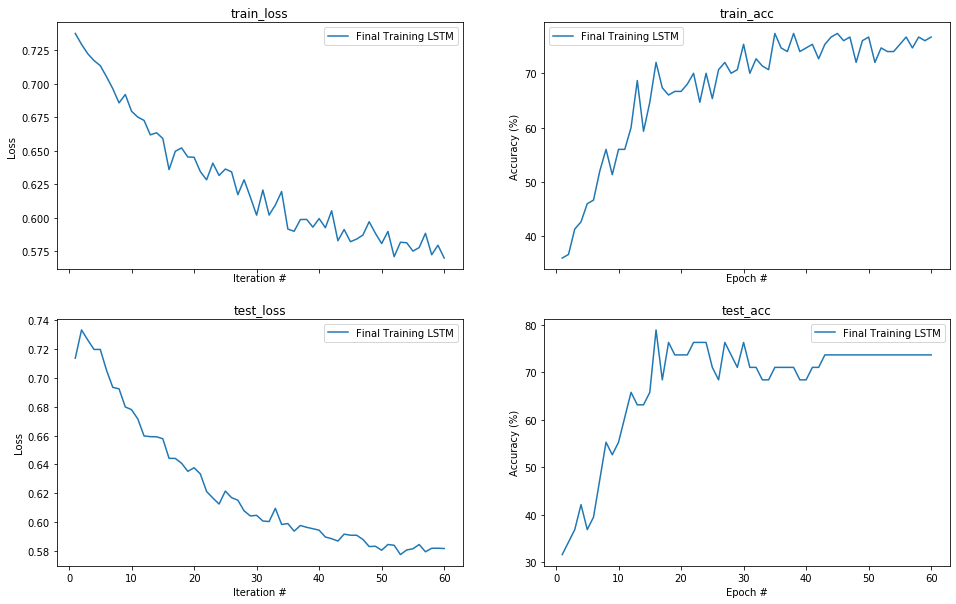

In [0]:
fig, clf = train_model(run_name, weight_decay=1e-3)

In [0]:
fig.suptitle("Bot Network Training")

Text(0.5, 0.98, 'Bot Network Training')

In [0]:
fig, clf2 = train_model(run_name, fig, use_TCN=True, rec_hidden_dim=256, weight_decay=1e-3)

===============================|STARTED TRAINING|===============================
Training with extractor TCN and use_gdelt=False:
--- EPOCH 1/60 ---
test_batch (Avg. Loss 0.717, Accuracy 26.3): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
--- EPOCH 2/60 ---
test_batch (Avg. Loss 0.741, Accuracy 31.6): 100%|██████████| 5/5 [00:05<00:00,  1.01s/it]
--- EPOCH 3/60 ---
test_batch (Avg. Loss 0.749, Accuracy 34.2): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]
--- EPOCH 4/60 ---
test_batch (Avg. Loss 0.742, Accuracy 44.7): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]
--- EPOCH 5/60 ---
test_batch (Avg. Loss 0.737, Accuracy 39.5): 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]
--- EPOCH 6/60 ---
test_batch (Avg. Loss 0.735, Accuracy 44.7): 100%|██████████| 5/5 [00:05<00:00,  1.02it/s]
--- EPOCH 7/60 ---
test_batch (Avg. Loss 0.738, Accuracy 39.5): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
--- EPOCH 8/60 ---
test_batch (Avg. Loss 0.737, Accuracy 50.0): 100%|██████████| 5/5 [00:04<00:00,  

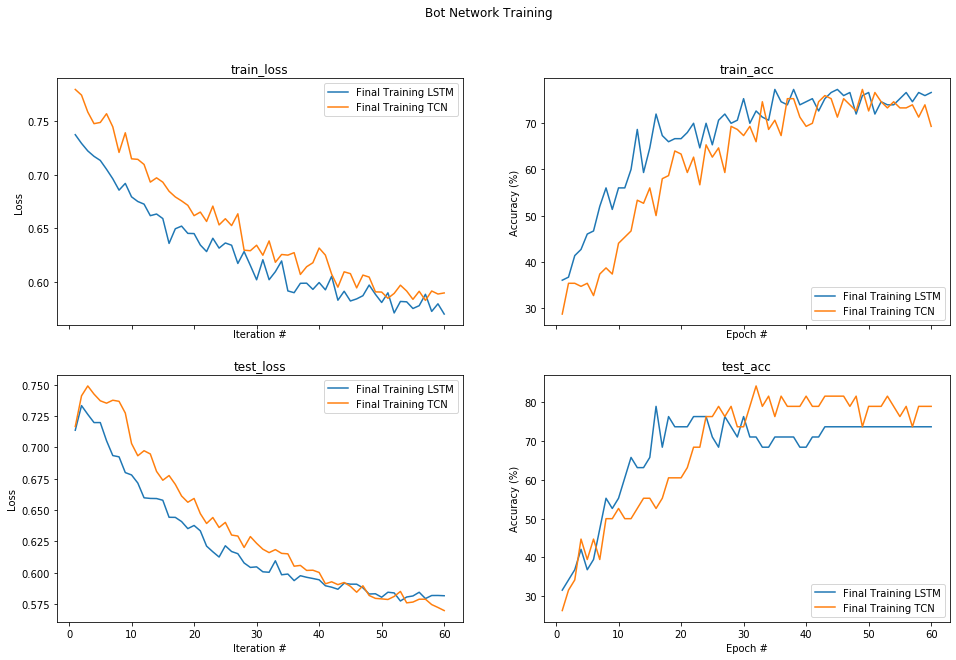

In [0]:
fig

In [0]:
fig, clf3 = train_model(run_name, fig, use_gdelt=True, weight_decay=1e-3)

===============================|STARTED TRAINING|===============================
Training with extractor LSTM and use_gdelt=True:
--- EPOCH 1/60 ---
test_batch (Avg. Loss 0.658, Accuracy 73.7): 100%|██████████| 5/5 [00:17<00:00,  2.66s/it]
--- EPOCH 2/60 ---
test_batch (Avg. Loss 0.642, Accuracy 73.7): 100%|██████████| 5/5 [00:17<00:00,  2.61s/it]
--- EPOCH 3/60 ---
test_batch (Avg. Loss 0.630, Accuracy 73.7): 100%|██████████| 5/5 [00:16<00:00,  2.55s/it]
--- EPOCH 4/60 ---
test_batch (Avg. Loss 0.619, Accuracy 71.1): 100%|██████████| 5/5 [00:16<00:00,  2.53s/it]
--- EPOCH 5/60 ---
test_batch (Avg. Loss 0.617, Accuracy 73.7): 100%|██████████| 5/5 [00:16<00:00,  2.53s/it]
--- EPOCH 6/60 ---
test_batch (Avg. Loss 0.606, Accuracy 73.7): 100%|██████████| 5/5 [00:17<00:00,  2.66s/it]
--- EPOCH 7/60 ---
test_batch (Avg. Loss 0.606, Accuracy 73.7): 100%|██████████| 5/5 [00:21<00:00,  3.14s/it]
--- EPOCH 8/60 ---
test_batch (Avg. Loss 0.607, Accuracy 76.3): 100%|██████████| 5/5 [00:17<00:00,  

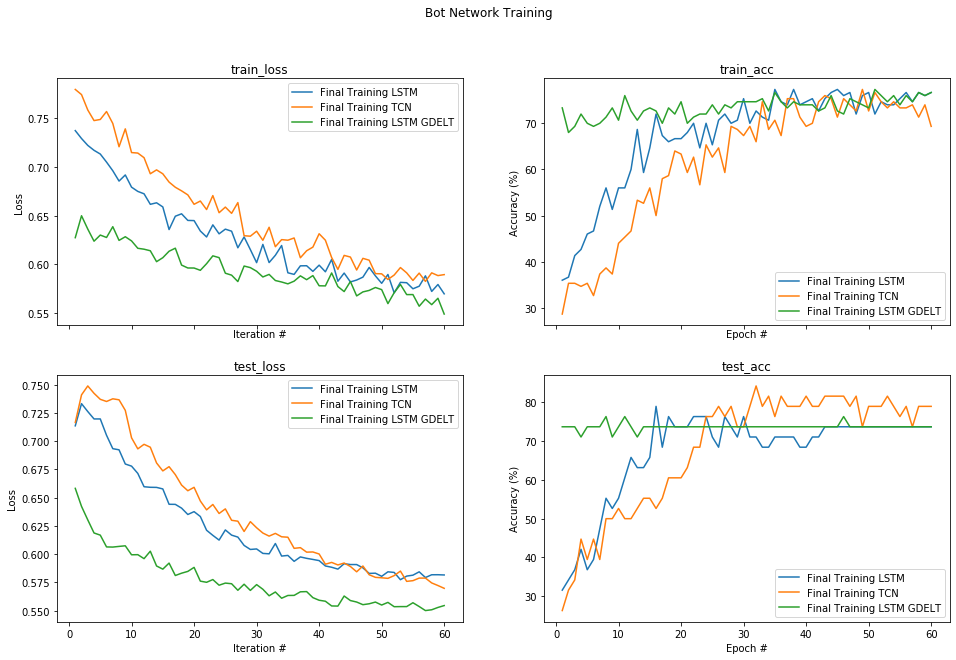

In [0]:
fig

In [0]:
fig, clf4 = train_model(run_name, fig, use_TCN=True, rec_hidden_dim=256, use_gdelt=True, weight_decay=1e-3)

===============================|STARTED TRAINING|===============================
Training with extractor TCN and use_gdelt=True:
--- EPOCH 1/60 ---
test_batch (Avg. Loss 0.690, Accuracy 47.4): 100%|██████████| 5/5 [00:17<00:00,  2.77s/it]
--- EPOCH 2/60 ---
test_batch (Avg. Loss 0.679, Accuracy 63.2): 100%|██████████| 5/5 [00:17<00:00,  2.64s/it]
--- EPOCH 3/60 ---
test_batch (Avg. Loss 0.666, Accuracy 60.5): 100%|██████████| 5/5 [00:18<00:00,  2.72s/it]
--- EPOCH 4/60 ---
test_batch (Avg. Loss 0.669, Accuracy 63.2): 100%|██████████| 5/5 [00:16<00:00,  2.55s/it]
--- EPOCH 5/60 ---
test_batch (Avg. Loss 0.661, Accuracy 60.5): 100%|██████████| 5/5 [00:17<00:00,  2.74s/it]
--- EPOCH 6/60 ---
test_batch (Avg. Loss 0.658, Accuracy 60.5): 100%|██████████| 5/5 [00:17<00:00,  2.61s/it]
--- EPOCH 7/60 ---
test_batch (Avg. Loss 0.649, Accuracy 60.5): 100%|██████████| 5/5 [00:16<00:00,  2.54s/it]
--- EPOCH 8/60 ---
test_batch (Avg. Loss 0.652, Accuracy 65.8): 100%|██████████| 5/5 [00:17<00:00,  2

In [0]:
fig

NameError: ignored

In [0]:
#plt.savefig(f"../drive/My\ Drive/{run_name}.png")

In [0]:
#! cp checkpoints/*.model ../drive/My\ Drive

In [0]:
print("!!!!!!!!!!!!!")